In [7]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%cd /home/psimmerl/Documents/work/EasyAI

import os

import numpy as np
from joblib import load
from main import parse_data, feats

import tensorflow as tf
from keras.models import load_model

import matplotlib as mpl
import matplotlib.pyplot as plt

##############

epoch = 107
mname = 'vae_LD6'

##############

model_dir = f'models/{mname}'

version = f'ckpt/epoch{epoch}'
if epoch < 1 and 'gan' in mname.lower():
    version = 'GAN'
if epoch < 1 and 'ae' in mname.lower():
    version = 'VAE'

print(mname, version)

##############

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

ELE_MASS = 0.000510999
PRO_MASS = 0.938272
KAON_MASS = 0.493677

data_dir = 'data/externel'

##############

model = load_model(f'{model_dir}/{version}')
sclr = load(f'{model_dir}/scaler.joblib')
print(model.name)
# trn, tst, _ = parse_data(data_dir+'/'+'eKpKm_fa2018_sp2019.root')
trn, tst, _ = parse_data(data_dir+'/'+'gen_rdf.root')


if 'generative_adversarial_network' in model.name:
  rlvs = tf.random.normal((len(trn), 64))#128))
  gen = model.generator(rlvs, training=False)

elif 'variational_auto_encoder' in model.name:
  rlvs = tf.random.normal((len(trn), 6))#model.latent_dim))#128))
  gen = model.decoder(rlvs, training=False)

real = dict(zip(feats, 
        sclr.inverse_transform(trn).T))
fake = dict(zip(feats, 
        sclr.inverse_transform(gen).T))


binfo = {
  'ePt'       : ('ePt',       'Electron P_{t};[GeV]'),
  'eEta'      : ('eEta',      'Electron #eta;'),
  'kpPt'      : ('kpPt',      'Kaon^{+} P_{t};'),
  'kpEta'     : ('kpEta',     'Kaon^{+} #eta;'),
  'kmPt'      : ('kmPt',      'Kaon^{-} P_{t};[GeV]'),
  'kmEta'     : ('kmEta',     'Kaon^{-} #eta;'),
  'ekpAngle'  : ('ekpAngle',  'Angle[Electron, Kaon^{+}];[deg]'),
  'ekmAngle'  : ('ekmAngle',  'Angle[Electron, Kaon^{-}];[deg]'),
  'kpkmAngle' : ('kpkmAngle', 'Angle[Kaon^{+}, Kaon^{-}];[deg]'),
  'phim'      : ('phim',      'Invariant K^{+}K^{-} Mass;Mass [GeV]'),
  'mm2'       : ('mm2',       'Missing Mass^{2};Mass^{2} [GeV^{2}]'),
  'q2'        : ('q2',        'Q^{2};Q^{2} [GeV^{2}]'),
  'logits'    : ('logits',    'GAN Logits;'),
}

nbins = 50
for k in real:
  if k in binfo:
    if 'deg' in binfo[k] and np.max(real[k]) < np.pi*2*1.05 :
      real[k] *= 180 / np.pi
      fake[k] *= 180 / np.pi
  else:
    binfo[k] = (k, k+';')

  xmin = np.min([real[k], fake[k]])
  xmax = np.max([real[k], fake[k]])

  xmin = np.quantile([real[k], fake[k]], 0.01)
  xmax = np.quantile([real[k], fake[k]], 0.99)

  binfo[k] += (nbins, xmin, xmax)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/psimmerl/Documents/work/EasyAI
vae_LD6 ckpt/epoch107
variational_auto_encoder
data/externel/gen_rdf.root
Evs - 1000000
Evs before eta cut - 1000000
Evs after eta cut - 841550
['ePt', 'eEta', 'kpPt', 'kpEta', 'kmPt', 'kmEta', 'ekpAngle', 'ekmAngle', 'kpkmAngle', 'q2', 'xb', 't', 'w']
(420775, 13) (420775, 13)


5544.934544791602


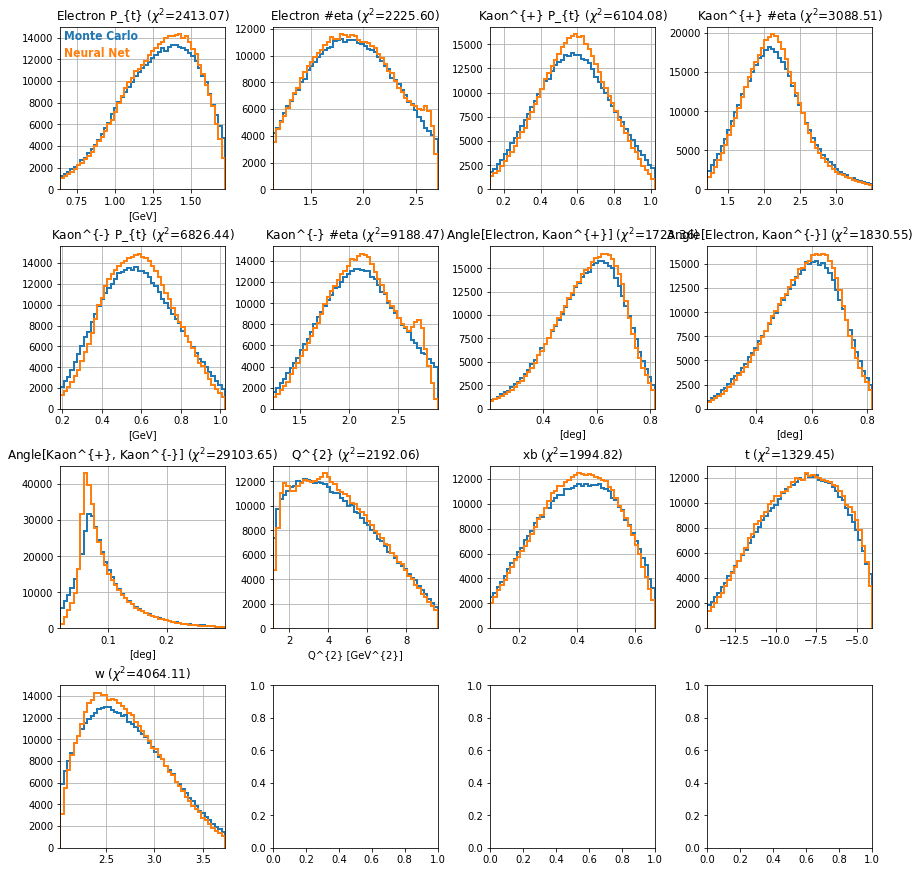

In [8]:
rows, cols = np.ceil(np.sqrt(trn.shape[1])), np.ceil(np.sqrt(trn.shape[1]))
rows, cols = int(rows), int(cols)
f, axs = plt.subplots(cols,rows, figsize=(3*cols,3*rows), constrained_layout=True)
axs = axs.flatten()
chi2_tot = 0

for iax, k in enumerate(real):
  ax = axs[iax]

  r = real[k]
  f = fake[k]
  var, title, nb, xmin, xmax = binfo[k]

  xlab = title.split(';')[1]
  title = title.split(';')[0]

  bins = np.linspace(xmin, xmax, nb)

  tvals, _, _ = ax.hist(r, histtype='step', bins=bins, lw=2, label='Monte Carlo')
  gvals, _, _ = ax.hist(f, histtype='step', bins=bins, lw=2, label='Neural Net')
  
  ax.set_xlim((xmin,xmax))
  ax.grid(True)

  chi2 = np.sum((tvals-gvals)**2/np.fmax(1, tvals))
  chi2_tot += chi2

  ax.set_title(title + f' ($\chi^2$={chi2:.2f})')
  ax.set_xlabel(xlab)

axs[0].text(0.02, 0.98, 'Monte Carlo', ha='left', va='top', transform=axs[0].transAxes, c='C0', weight='bold', stretch='condensed', size=12)
axs[0].text(0.02, 0.88, 'Neural Net', ha='left', va='top', transform=axs[0].transAxes, c='C1', weight='bold', stretch='condensed', size=12)

print(chi2_tot / trn.shape[1])


NameError: name 'dtrn' is not defined

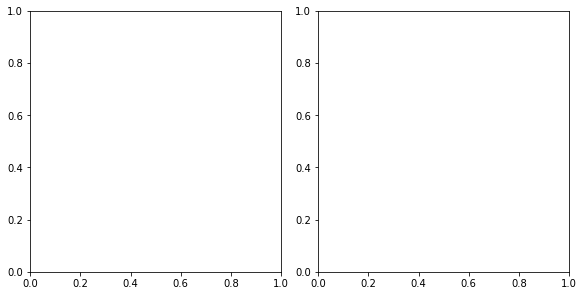

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
f, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
axs = axs.flatten()

xmin, xmax = np.quantile([dtrn, dgen], 0.001), np.quantile([dtrn, dgen], 0.999)
bins = np.linspace(xmin, xmax, 50)
axs[0].hist(dtrn, histtype='step', bins=bins, lw=2, label='Experimenal')
axs[0].hist(dgen, histtype='step', bins=bins, lw=2, label='Generated')
axs[0].set_xlim((xmin,xmax))
axs[0].grid(True)
axs[0].legend()
axs[0].set_title('Discriminator Logits')

dis_score = np.c_[dtrn, dgen].flatten()
dis_label = np.c_[np.ones_like(dtrn), np.zeros_like(dgen)].flatten()
fpr, tpr, thresholds = roc_curve(dis_label, dis_score)
roc_auc = roc_auc_score(dis_label, dis_score)

axs[1].plot(fpr, tpr, label=f'{roc_auc:.3f}', lw=2)
axs[1].plot([0,1],[0,1], 'k--', alpha=0.5)
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlim((0,1))
axs[1].set_ylim((0,1));
axs[1].set_title('Reciever-Operating Curve');
